In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/dogImages/train')
valid_files, valid_targets = load_dataset('data/dogImages/valid')
test_files, test_targets = load_dataset('data/dogImages/test')

# load list of dog names
# change 20 to 27 to get names correctly
dog_names = [item[27:-1] for item in sorted(glob("data/dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

# print(dog_names)

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


Number of faces detected: 1


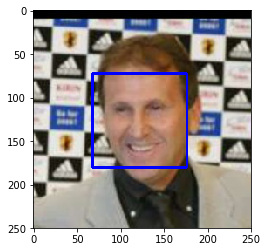

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
#face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[1024])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [4]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

human_in_human_files = [face_detector(img) for img in human_files_short]
human_in_dog_files = [face_detector(img) for img in dog_files_short]

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
    
print('percentage of human face in human files is {}%'.format(sum(human_in_human_files)))
print('percentage of human face in dog files is : {}%'.format(sum(human_in_dog_files)))


percentage of human face in human files is 99%
percentage of human face in dog files is : 12%


In [10]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')


In [11]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


In [12]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [13]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dog_in_human_files = [dog_detector(img) for img in human_files_short]
dog_in_dog_files = [dog_detector(img) for img in dog_files_short]

print('percentage of human face in human files is : {}%'.format(sum(dog_in_human_files)))
print('percentage of human face in dog files is : {}%'.format(sum(dog_in_dog_files)))

percentage of human face in human files is : 1%
percentage of human face in dog files is : 100%


In [15]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:04<00:00, 194.56it/s]


In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.

model.add(Conv2D(16, kernel_size = (3,3), strides = (1,1), activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, kernel_size = (3,3),  activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(GlobalAveragePooling2D())

model.add(Dense(300, activation='relu'))

model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

In [17]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Inception.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 79s 12ms/step - loss: 4.8830 - acc: 0.0084 - val_loss: 4.8696 - val_acc: 0.0108

Epoch 00001: val_loss improved from inf to 4.86961, saving model to saved_models/weights.best.Inception.hdf5
Epoch 2/5
6680/6680 [==============================] - 77s 12ms/step - loss: 4.8625 - acc: 0.0112 - val_loss: 4.8168 - val_acc: 0.0168

Epoch 00002: val_loss improved from 4.86961 to 4.81681, saving model to saved_models/weights.best.Inception.hdf5
Epoch 3/5
6680/6680 [==============================] - 76s 11ms/step - loss: 4.7731 - acc: 0.0198 - val_loss: 4.7406 - val_acc: 0.0216

Epoch 00003: val_loss improved from 4.81681 to 4.74055, saving model to saved_models/weights.best.Inception.hdf5
Epoch 4/5
6680/6680 [==============================] - 77s 12ms/step - loss: 4.6782 - acc: 0.0234 - val_loss: 4.6700 - val_acc: 0.0287

Epoch 00004: val_loss improved from 4.74055 to 4.66996, saving model to sa

In [19]:
model.load_weights('saved_models/weights.best.Inception.hdf5')



In [20]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)

print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.2297%


In [22]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']



In [23]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [24]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [25]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 272us/step - loss: 12.3204 - acc: 0.1115 - val_loss: 10.5814 - val_acc: 0.1892

Epoch 00001: val_loss improved from inf to 10.58141, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
6680/6680 [==============================] - 1s 113us/step - loss: 9.8090 - acc: 0.2804 - val_loss: 9.7422 - val_acc: 0.2695

Epoch 00002: val_loss improved from 10.58141 to 9.74224, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
6680/6680 [==============================] - 1s 113us/step - loss: 9.0589 - acc: 0.3594 - val_loss: 9.2307 - val_acc: 0.3210

Epoch 00003: val_loss improved from 9.74224 to 9.23073, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
6680/6680 [==============================] - 1s 114us/step - loss: 8.5983 - acc: 0.4030 - val_loss: 8.9847 - val_acc: 0.3437

Epoch 00004: val_loss improved from 9.23073 to 8.98465, saving model to saved_

In [31]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')


In [49]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)



Test accuracy: 47.3684%


In [78]:
from extract_bottleneck_features import *
def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]


In [79]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('DogInceptionV3Data.npz')
train_Inception = bottleneck_features['train']
valid_Inception = bottleneck_features['valid']
test_Inception = bottleneck_features['test']


In [80]:
Inception_model = Sequential()
Inception_model.add(GlobalAveragePooling2D(input_shape=train_Inception.shape[1:]))
Inception_model.add(Dense(133, activation='softmax'))

Inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [81]:
Inception_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [82]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Inception.hdf5', 
                               verbose=1, save_best_only=True)

Inception_model.fit(train_Inception, train_targets, 
          validation_data=(valid_Inception, valid_targets),
          epochs=10, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 3s 420us/step - loss: 1.2182 - acc: 0.7042 - val_loss: 0.6606 - val_acc: 0.8084

Epoch 00001: val_loss improved from inf to 0.66063, saving model to saved_models/weights.best.Inception.hdf5
Epoch 2/10
6680/6680 [==============================] - 2s 232us/step - loss: 0.3821 - acc: 0.8793 - val_loss: 0.7355 - val_acc: 0.7880

Epoch 00002: val_loss did not improve from 0.66063
Epoch 3/10
6680/6680 [==============================] - 2s 232us/step - loss: 0.2436 - acc: 0.9243 - val_loss: 0.6303 - val_acc: 0.8299

Epoch 00003: val_loss improved from 0.66063 to 0.63030, saving model to saved_models/weights.best.Inception.hdf5
Epoch 4/10
6680/6680 [==============================] - 2s 233us/step - loss: 0.1571 - acc: 0.9482 - val_loss: 0.6302 - val_acc: 0.8383

Epoch 00004: val_loss improved from 0.63030 to 0.63022, saving model to saved_models/weights.best.Inception.hdf5
Epoch 5/10
6680/668

In [83]:
Inception_model.load_weights('saved_models/weights.best.Inception.hdf5')

In [84]:
Inception_predictions = [np.argmax(Inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Inception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Inception_predictions)==np.argmax(test_targets, axis=1))/len(Inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.5359%


In [85]:
from extract_bottleneck_features import *

def Inception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Inception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [86]:
def show_pic(img_path):
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # cv2 reads as BGR, so want as RGB for matplotlib
    plt.show()
    
def predict_breed(img_path):
    return Inception_predict_breed(img_path)

def breed_algorithm(img_path):
    if face_detector(img_path):
        print("Hello, human!")
        show_pic(img_path)
        print("You look most like a ...")
        print(predict_breed(img_path))
    elif dog_detector(img_path):
        print("Woof woof, dog!")
        show_pic(img_path)
        print("Your predicted breed is a ...")
        print(predict_breed(img_path))
    else:
        print("An error has occurred, as the subject does not appear to be a human or dog.")
        show_pic(img_path)

Hello, human!


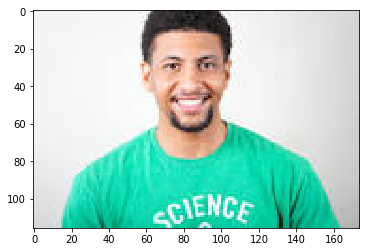

You look most like a ...
sset_hound
Woof woof, dog!


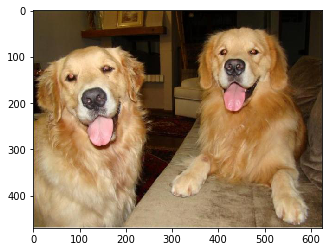

Your predicted breed is a ...
lden_retriever
Woof woof, dog!


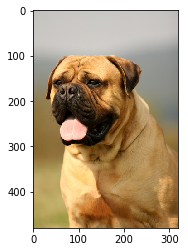

Your predicted breed is a ...
llmastiff


In [92]:
for file_path in glob('test_images/*.jpg'):
    breed_algorithm(file_path)
